In [40]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [41]:
import numpy as np
import scipy

import sys
sys.path.insert(0,"..")
import matplotlib
import matplotlib.pylab as pl
from matplotlib import pyplot as plt
import seaborn as sns

import sklearn.pipeline
import sklearn
import sklearn.model_selection
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

import mne.decoding

import ccs_eeg_utils

In [42]:
epochs = ccs_eeg_utils.get_classification_dataset(typeInt=4)

loading subject 1 with runs [6, 10, 14]
Extracting EDF parameters from /home/ehinger/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /home/ehinger/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /home/ehinger/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-

In [43]:
epochs

Number of events,45
Events,feet: 24hands: 21
Time range,-1.000 – 4.000 sec
Baseline,off


### The EEG Motor Movement/Imagery Dataset
Information on the dataset at hand can be found [here](https://physionet.org/content/eegmmidb/1.0.0/) - a total of 109 subjects exist.

### Big picture:

Subjects imagine opening left & right hand or hand & feet. We want to decode which they do, in case they are doing that for real, or when they are just imagining it (brain reading 🤯!)

- We will use Common Spatial Patterns to get a good feature space and LinearDiscriminatAnalysis as a simple decoder. Of course you can always change things up and see how it changes.

- We will use cross-validation to preclude overfitting

- We will apply the weights over all timepoints to get a score across time

### Let's get started
Our training data should exclude the evoked response, because it will not be sustained throughout the trial. We will make a copy of the epochs and crop it between 1 and 2 seconds (`epochs_train.crop(tmin=1.,tmax=2.)`)

**T:** To get a first look at the training data, 1) average the epochs_train over time and plot the channels C3 and C4 as x/y axis in a scatter plot. Color the datapoints according to the labels. Data you can get using `.get_data(picks=["C3","C4"])`, labels via `.events`

**Q:** Would this be easy or difficult to separate with a linear classifier?


[3 2 2 3 2 3 3 2 2 3 3 2 2 3 3 2 3 3 2 3 2 2 3 3 2 2 3 3 2 3 3 2 3 2 2 3 2
 3 2 3 3 2 3 2 3]


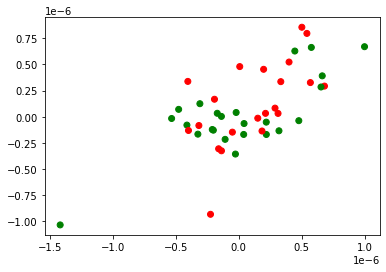

In [44]:
epochs_train = epochs.copy().crop(tmin=1., tmax=2.)

data = epochs_train.get_data(picks=['C3','C4']).mean(axis=2)
labels = epochs.events[:,-1]
print(labels)
plt.scatter(data[:,0],data[:,1],color=np.array(["red","green"])[labels-2]);


### CSP Feature Selection
We can define a CommonSpatialPatterns object using `csp = mne.decoding.CSP(n_components=2)`

To fit the CSP we have to give it the data and the labels. For now we just want to look at the CSP, not run a classifier for it, so we dont worry about any overfit etc.

**T:** `csp.fit_transform(epochs_data, labels)` will fit it and `csp.plot_filters(epochs.info)` and `csp.plot_patterns(epochs.info)` will plot filter and activation. 

**Q:** Let's say you invite a subject again, but are allowed to only measure 5 channels not the 64. Which of the two plots would you choose to inform which channels to measure? In other words, does any of the plot tell you where the information to decode is strongest?

In [45]:
csp = mne.decoding.CSP(n_components=2)
csp.fit_transform(epochs.get_data(), labels)
csp

Computing rank from data with rank=None
    Using tolerance 0.00025 (2.2e-16 eps * 64 dim * 1.7e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00026 (2.2e-16 eps * 64 dim * 1.9e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.


CSP(component_order='mutual_info', cov_est='concat', cov_method_params=None,
  log=None, n_components=2, norm_trace=False, rank=None, reg=None,
  transform_into='average_power')

Computing rank from data with rank=None
    Using tolerance 0.00025 (2.2e-16 eps * 64 dim * 1.7e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00026 (2.2e-16 eps * 64 dim * 1.9e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.


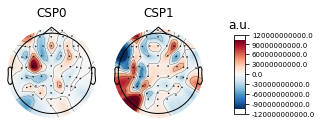

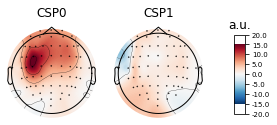

In [46]:
csp = mne.decoding.CSP(n_components=2)
csp.fit_transform(epochs.get_data(), labels)
csp.plot_filters(epochs.info);
csp.plot_patterns(epochs.info);




**T:** Finally, let's weight/transform the data to the fitted CSP components using `csp_data = csp.transform(data)`. Note that because `csp(...,transform_into="average_power")` is set by default, we will get data without a time-dimension, thus already aggregated. Plot the datapoints against each other, how easy is it now to define a classifier?

In [48]:
epochs.get_data().shape

(45, 64, 801)

In [50]:
csp_data = csp.transform(epochs.get_data())
csp_data.shape

(45, 2)

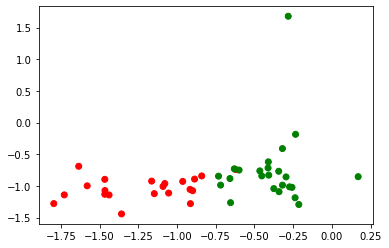

In [51]:
csp_data = csp.transform(epochs.get_data())

plt.scatter(csp_data[:,0],csp_data[:,1],color=np.array(["red","green"])[labels-2])

### LDA Classification
Let's use the LDA classifier (you could use any other if you fancy, up to you - LDA is a fast and simple one).

You need to:
1. Construct the classifier  via 
```python
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis()
``` 
2. Reshape the csp_data to conform to labels x features (2D instead of 3D) e.g. using `flattenData = csp_data.reshape(csp_data.shape[0],-1)`

3. Fit the LDA using `lda.fit(data,labels)`

4. Score it using `lda.score(data,labels)`

*Note: we are doing a cardinal sin: Training and testing on the same data. How to fix that is next.*

**T:** How well can you classify?


In [52]:
csp_data.reshape(csp_data.shape[0],-1).shape

(45, 2)

In [59]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis()
# flattenData = csp_data.reshape(csp_data.shape[0],-1)

lda.fit(csp_data, labels) # fit on training
print(lda.score(csp_data,labels))

0.9777777777777777


### Crossvalidation
To work against overfitting, we use crossvalidate and use some functions from sklearn for it.
We will use a stratifiedShuffleSplit, which will split our data in training and test sets, but in a stratified way. Thus we dont have to worry about under/oversampling between our classes for now.

```python
cv = sklearn.model_selection.StratifiedShuffleSplit(10, test_size=0.2, random_state=42)
cv_split = cv.split(epochs_train.get_data(),labels)
```

Next we can walk though each test/train, fit CSP, fit LDA and evaluate. I will give you the skeleton and you only have to fill in the XXX to speed up programming :).

```python
score_list = []
for train_idx, test_idx in cv_split:
    y_train, y_test = labels[train_idx], labels[test_idx]

    csp.fit_transform(epochs_train.get_data()[XXX_idx], y_XXX)
    X_train = csp.transform(epochs_train.get_data()[XXX_idx])
    X_test  = csp.transform(epochs_train.get_data()[XXX_idx])

    lda.fit(X_XXX, y_XXX) 
    score = lda.score(X_XXX,y_XXX)
    score_list.append(score)
```


In [60]:
### Crossvalidation
cv = sklearn.model_selection.StratifiedShuffleSplit(10, test_size=0.2, random_state=42)
cv_split = cv.split(epochs_train.get_data(),labels)
next(cv_split)

(array([ 1, 19, 37, 28, 27, 14, 26, 18, 17, 25, 34, 20, 11, 35,  5, 44,  9,
        32, 30, 15, 29, 33,  6,  7,  4, 24,  8, 13, 10, 36, 40, 16, 38, 43,
        23,  2]),
 array([42, 41, 31, 21,  3, 39,  0, 22, 12]))

In [61]:

### Crossvalidation
cv = sklearn.model_selection.StratifiedShuffleSplit(10, test_size=0.2, random_state=42)
cv_split = cv.split(epochs_train.get_data(),labels)


score_list = []
for train_idx, test_idx in cv_split:
    y_train, y_test = labels[train_idx], labels[test_idx]

    csp.fit_transform(epochs_train.get_data()[train_idx], y_train)
    X_train = csp.transform(epochs_train.get_data()[train_idx])
    
    X_test = csp.transform(epochs_train.get_data()[test_idx])

    lda.fit(X_train, y_train) # fit on training
    score = lda.score(X_test,y_test)
    score_list.append(score)
print(np.mean(score_list))

Computing rank from data with rank=None
    Using tolerance 0.00012 (2.2e-16 eps * 64 dim * 8.2e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.0001 (2.2e-16 eps * 64 dim * 7.2e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00012 (2.2e-16 eps * 64 dim * 8.3e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.9e-05 (2.2e-16 eps * 64 dim * 7e+09  max singular value)
   

### Decoding via Pipeline
Typically you would like to use a pipeline-system to easily exchange components. We are using the scikit pipeline
We need several incredients: 

1. Training-Data & labels
2. Pipeline with feature selection (CSP) & Classifier (LDA)
3. Cross-Validation scheme
 
#### Implementation

2. CSP and LDA & pipeline
 ```python
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import mne.decoding
lda = LinearDiscriminantAnalysis()
csp = mne.decoding.CSP(n_components=2) # default is 4, typically youd like to do a nested cross-val hyperparam search. 2 is likely too low
% and the pipeline simply:
pipe = sklearn.pipeline.Pipeline([('CSP', csp), ('LDA', lda)])
 ```


3. The sklearn Cross-validation pipeline is run like this
 ```python
import sklearn.model_selection
cv = sklearn.model_selection.StratifiedShuffleSplit(10, test_size=0.2, random_state=0)
scores = sklearn.model_selection.cross_val_score(pipe, trainingData, labels, cv=cv, n_jobs=1)
 ```

In [62]:
lda = LinearDiscriminantAnalysis()
csp = mne.decoding.CSP(n_components=2)

In [67]:
pipe = sklearn.pipeline.Pipeline([('CSP', csp), ('LDA', lda)])
cv = sklearn.model_selection.StratifiedShuffleSplit(10, test_size=0.2, random_state=42)
scores = sklearn.model_selection.cross_val_score(pipe, epochs_train.get_data(), labels, cv=cv, n_jobs=1)

Computing rank from data with rank=None
    Using tolerance 0.00012 (2.2e-16 eps * 64 dim * 8.2e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.0001 (2.2e-16 eps * 64 dim * 7.2e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00012 (2.2e-16 eps * 64 dim * 8.3e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.9e-05 (2.2e-16 eps * 64 dim * 7e+09  max singular value)
   

In [68]:
print(np.mean(scores))
print(scores)
print(score_list)

0.9111111111111111
[1.         1.         0.88888889 0.88888889 0.77777778 0.88888889
 0.88888889 1.         1.         0.77777778]
[1.0, 1.0, 0.8888888888888888, 0.8888888888888888, 0.7777777777777778, 0.8888888888888888, 0.8888888888888888, 1.0, 1.0, 0.7777777777777778]


**Q:** What is the accuracy of the classifier? What is the chance level?

In [69]:
print("Accuracy: {:.1f}%, ".format(scores.mean()*100))
# chance level should be 50% because we used stratified cross validation

Accuracy: 91.1%, 


## Extensions 
This formulations with the pipelines etc. is neat, because we can simply exchange parts of the pipeline and see what happens.
Note though, that you are performing multiple testing and are very easily overfitting to your dataset.

Thus in principle, you would like to explore some options with one set of subjects, then test the pipeline on another set of subjects. But this is a bit too involved for the homework.

### Remove CSP
Instead of applying a feature selection, maybe we can learn from the "raw" data? 
**T:** Replace the "csd" in the pipeline with `mne.decoding.Vectorizer()`, this will ensure the reshaping of the features we performed earlier.

**Q:** What is the accuracy now?


In [70]:
pipe_simple = sklearn.pipeline.Pipeline([('vector',mne.decoding.Vectorizer()),('LDA', lda)])
cv = sklearn.model_selection.StratifiedShuffleSplit(10, test_size=0.2, random_state=0)
scores = sklearn.model_selection.cross_val_score(pipe_simple, epochs_train.get_data(), labels, cv=cv, n_jobs=1)
print("Accuracy: {:.1f}%, ".format(scores.mean()*100))


Accuracy: 51.1%, 


### Classify over time
Next we will fit a classifier for each timepoint and test it on that timepoint (you have to use the simple pipeline, see below)
For this the convenience function `timeDecode = mne.decoding.SlidingEstimator(pipe)` exists. This function performs the pipeline on the last dimension (which is currently time).

Because we will get multiple scores per cross-val, we also have to switch our scorer to `mne.decoding.cross_val_multiscore(timeDecode,...)`.

**T:** Plot the performance against time

**Bonus T:** You can also use `mne.decoding.GeneralizingEstimator(...)` to get the temporal decoding matrix (increased runtime warning)

In [71]:
timeDecode = mne.decoding.SlidingEstimator(pipe_simple)
scores = mne.decoding.cross_val_multiscore(timeDecode, epochs.copy().resample(20).get_data(), labels, cv=cv,n_jobs=1)

  0%|          | Fitting SlidingEstimator : 0/100 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/100 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/100 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/100 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/100 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/100 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/100 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/100 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/100 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/100 [00:00<?,       ?it/s]

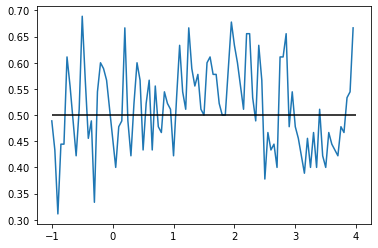

In [72]:
plt.plot(epochs.copy().resample(20).times,scores.mean(axis=0))
plt.hlines(0.5,-1,4,'k')

In [73]:
timeDecode = mne.decoding.GeneralizingEstimator(pipe_simple)
scores = mne.decoding.cross_val_multiscore(timeDecode, epochs.copy().resample(20).get_data(), labels, cv=2,n_jobs=1) # resample speeds it up a lot! 

  0%|          | Fitting GeneralizingEstimator : 0/100 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/10000 [00:00<?,       ?it/s]

  0%|          | Fitting GeneralizingEstimator : 0/100 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/10000 [00:00<?,       ?it/s]

You might be surprised - or not - by the performance you observed. Applying this to a dataset with actual evoked responses, will likely be much more satisfactory.

The reason seems clear, we would need CSP in between. But CSP needs multiple timepoints and doesntwork with SlidingEstimator. We have to do it manually.

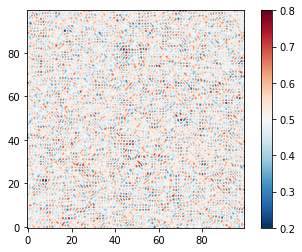

In [74]:
im = plt.imshow(scores.mean(axis=0), interpolation='lanczos', origin='lower', cmap='RdBu_r',vmin=0.2, vmax=0.8)
plt.colorbar()

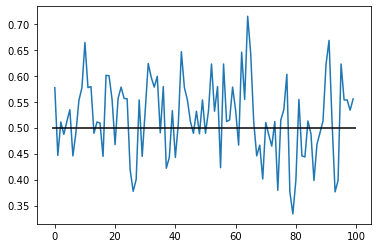

In [75]:
plt.plot(np.diag(scores.mean(axis=0)))
plt.hlines(0.5,-1,100,'k')

In [80]:
w_size = 0.7
timeVec = epochs.copy().resample(40).times
timeVec = timeVec[::10]
t_scores = np.zeros(len(timeVec))
for t, w_time in enumerate(timeVec):
        print("{}/{}".format(t,len(timeVec)))
        # Center the min and max of the window
        w_tmin = w_time - w_size / 2.
        w_tmax = w_time + w_size / 2.

        # stop the program if the timewindow is outside of our epoch
        if w_tmin < timeVec[0]:
            continue
        if w_tmax > timeVec[len(timeVec)-1]:
            continue
        # Crop data into time-window of interest
        X = epochs.copy().resample(40).crop(w_tmin, w_tmax).get_data()

        # Save mean scores over folds for each frequency and time window
        t_scores[t] = np.mean( sklearn.model_selection.cross_val_score(estimator=pipe, X=X, y=labels,
                                                     scoring='roc_auc', cv=2,
                                                     n_jobs=1), axis=0)

0/20
1/20
2/20
Computing rank from data with rank=None
    Using tolerance 3.1e-05 (2.2e-16 eps * 64 dim * 2.2e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.2e-05 (2.2e-16 eps * 64 dim * 2.3e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.1e-05 (2.2e-16 eps * 64 dim * 2.2e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.5e-05 (2.2e-16 eps * 64 dim * 2.4e+09  max s

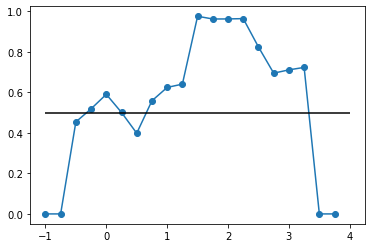

In [81]:
plt.plot(timeVec,t_scores,'o-')
plt.hlines(0.5,-1,4,'k')